# Example from Pytorch-Tabnet

In [28]:
from pytorch_tabnet.tab_model import TabNetRegressor

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

In [134]:
def predict(model, x, y):
    y_pred = model.predict(x).reshape(-1)
    y_true = y.reshape(-1)
    test_score = mean_squared_error(y_pred=y_pred, y_true=y_true)
    print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
    print(f"FINAL TEST SCORE FOR {dataset_name} : {test_score}")
    return y_true, y_pred


def plot_results(y_true, y_pred):
    plt.figure(figsize=(15, 8))
    df_result = pd.DataFrame({'y_true': y_true,
                             'y_pred': y_pred}).reset_index().rename(columns={'index': 'date'})
    df_result_melted = pd.melt(df_result, id_vars=['date'], value_vars=['y_true', 'y_pred'])
    ax = sns.lineplot(x='date', y='value', hue='variable', data=df_result_melted)

# Download census-income dataset

In [11]:
url = 'https://raw.githubusercontent.com/BhavyaGulati/TimeSeries-FlightPassesngerPrediction/master/international-airline-passengers.csv'

In [12]:
# url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'international-airline-passengers'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [13]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())

---
# Load data

In [54]:
data = pd.read_csv(out, header=None).rename(columns={0: 'date', 1: 'passengers'})
# clean
data = data.loc[~(data['date']== 'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60')]
data['date'] = pd.to_datetime(data['date'], format='%Y-%m')
data.sort_values('date', inplace=True)
data.head()

,date,passengers
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0


In [55]:
display(data.shape)
display(data.shape[0] / 12)

(144, 2)

12.0

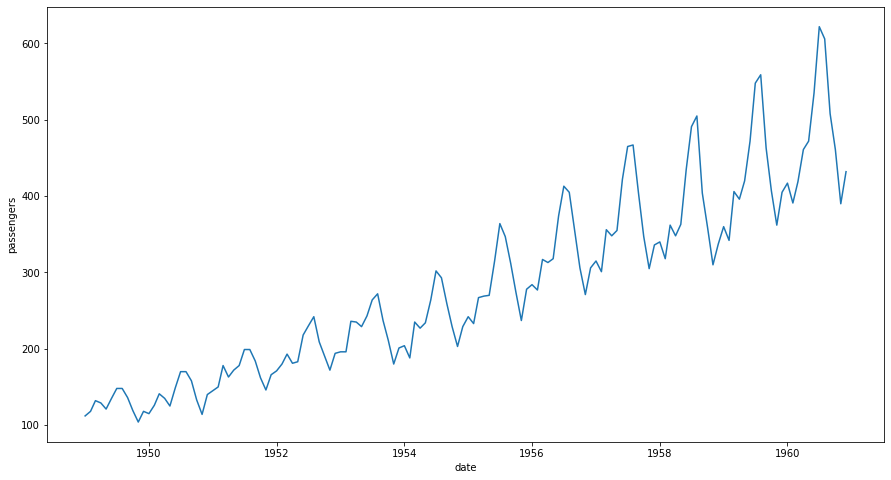

In [56]:
plt.figure(figsize=(15, 8))
ax = sns.lineplot(x='date', y='passengers', data=data)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

We can see that the timeseries have clearly two components: 
* Seasonality
* Trend

# Train-Validation-Test Split

In [57]:
validation_fraction, test_fraction = (0.2, 0.2)
train_fraction = 1 - validation_fraction - test_fraction

Because we are dealing with timeseries data, we will train on the first segment of data, validate with the second one, and test with the most recent chunk.

In [61]:
n_train = int(round(len(data) * train_fraction))
print(f'Using {n_train} points to train')

n_val = int(round(len(data) * validation_fraction))
print(f'Using {n_val} points to validate')

n_test = len(data) - n_train - n_val
print(f'Using {n_test} points to test')

Using 86 points to train
Using 29 points to validate
Using 29 points to test


# Feature Generation

Given the properties seen on the timeseries we create features to try to capture those patterns:
* Seasonality: passengers_-1
* Trend: passengers_-12

In [79]:
X_y = data.copy()

In [80]:
# X_y['month'] = X_y['date'].dt.month
# X_y['year'] = X_y['date'].dt.year

# passengers the previous month
X_y['passengers_-1'] = X_y['passengers'].shift(1) 
# fill na strategy: use the same
X_y.loc[X_y['passengers_-1'].isna(), 'passengers_-1'] = X_y.loc[X_y['passengers_-1'].isna(), 'passengers']

In [81]:
# passengers last year
X_y['passengers_-12'] = X_y['passengers'].shift(12) 
# fill na strategy: use the same
X_y.loc[X_y['passengers_-12'].isna(), 'passengers_-12'] = X_y.loc[X_y['passengers_-12'].isna(), 'passengers']

In [184]:
def _generate_autoregressive_feature(X_y, step=1):
    X_y[f'passengers_-{step}'] = X_y['passengers'].shift(step) 
    X_y.loc[X_y[f'passengers_-{step}'].isna(), f'passengers_-{step}'] = X_y.loc[X_y[f'passengers_-{step}'].isna(), 'passengers']
    return X_y

In [192]:
FEATURES_TO_USE = []
for step in range(1, 13):
    X_y = _generate_autoregressive_feature(X_y, step=step)
    FEATURES_TO_USE.append(f'passengers_-{step}')

In [193]:
X_y.head(13)

,date,passengers,month,year,passengers_-1,passengers_-12,passengers_-2,passengers_-3,passengers_-4,passengers_-5,passengers_-6,passengers_-7,passengers_-8,passengers_-9,passengers_-10,passengers_-11
0,1949-01-01,112.0,1,1949,112.0,112.0,112.0,112.0,112.0,112.0,112.0,112.0,112.0,112.0,112.0,112.0
1,1949-02-01,118.0,2,1949,112.0,118.0,118.0,118.0,118.0,118.0,118.0,118.0,118.0,118.0,118.0,118.0
2,1949-03-01,132.0,3,1949,118.0,132.0,112.0,132.0,132.0,132.0,132.0,132.0,132.0,132.0,132.0,132.0
3,1949-04-01,129.0,4,1949,132.0,129.0,118.0,112.0,129.0,129.0,129.0,129.0,129.0,129.0,129.0,129.0
4,1949-05-01,121.0,5,1949,129.0,121.0,132.0,118.0,112.0,121.0,121.0,121.0,121.0,121.0,121.0,121.0
5,1949-06-01,135.0,6,1949,121.0,135.0,129.0,132.0,118.0,112.0,135.0,135.0,135.0,135.0,135.0,135.0
6,1949-07-01,148.0,7,1949,135.0,148.0,121.0,129.0,132.0,118.0,112.0,148.0,148.0,148.0,148.0,148.0
7,1949-08-01,148.0,8,1949,148.0,148.0,135.0,121.0,129.0,132.0,118.0,112.0,148.0,148.0,148.0,148.0
8,1949-09-01,136.0,9,1949,148.0,136.0,148.0,135.0,121.0,129.0,132.0,118.0,112.0,136.0,136.0,136.0
9,1949-10-01,119.0,10,1949,136.0,119.0,148.0,148.0,135.0,121.0,129.0,132.0,118.0,112.0,119.0,119.0


In [194]:
X_y.isna().sum()

date              0
passengers        0
month             0
year              0
passengers_-1     0
passengers_-12    0
passengers_-2     0
passengers_-3     0
passengers_-4     0
passengers_-5     0
passengers_-6     0
passengers_-7     0
passengers_-8     0
passengers_-9     0
passengers_-10    0
passengers_-11    0
dtype: int64

In [195]:
X = X_y[FEATURES_TO_USE].values
y = X_y[['passengers']].values

In [196]:
X_train, y_train = X[:n_train], y[:n_train]
X_val, y_val = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
X_test, y_test = X[n_train+n_val:], y[n_train + n_val:]

# Simple preprocessing

Label encode categorical features and fill empty cells.

# Network parameters

In [197]:
tabnet_regressor = TabNetRegressor()

Device used : cuda


# Training

In [198]:
max_epochs = 1000

In [199]:
tabnet_regressor.fit(
    X_train=X_train, y_train=y_train,
    X_valid=X_val, y_valid=y_val,
    max_epochs=max_epochs,
    patience=50,
    batch_size=1024, 
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
) 

Will train until validation stopping metric hasn't improved in 50 rounds.
---------------------------------------
| EPOCH |  train  |   valid  | total time (s)
| 1     | -43299.53516 |  -208599.26562 |   0.1       
| 2     | -43129.93750 |  -140763.35938 |   0.1       
| 3     | -42775.24609 |  -71415.59375 |   0.1       
| 4     | -42554.10156 |  -55690.41406 |   0.2       
| 5     | -42300.41016 |  -42232.28906 |   0.2       
| 6     | -42113.36328 |  -42442.02734 |   0.3       
| 7     | -41925.14062 |  -35053.64062 |   0.3       
| 8     | -41711.73438 |  -33205.78125 |   0.4       
| 9     | -41552.71484 |  -38209.48828 |   0.4       
| 10    | -41371.12500 |  -40855.51172 |   0.4       
| 11    | -41161.45312 |  -31503.08594 |   0.5       
| 12    | -41028.82422 |  -32398.54297 |   0.5       
| 13    | -40827.54297 |  -28331.06445 |   0.6       
| 14    | -40632.41016 |  -19975.83008 |   0.6       
| 15    | -40413.14062 |  -13842.86816 |   0.6       
| 16    | -40197.96094 |  -1

BEST VALID SCORE FOR international-airline-passengers : 569.7008056640625
FINAL TEST SCORE FOR international-airline-passengers : 1149.1233867287283


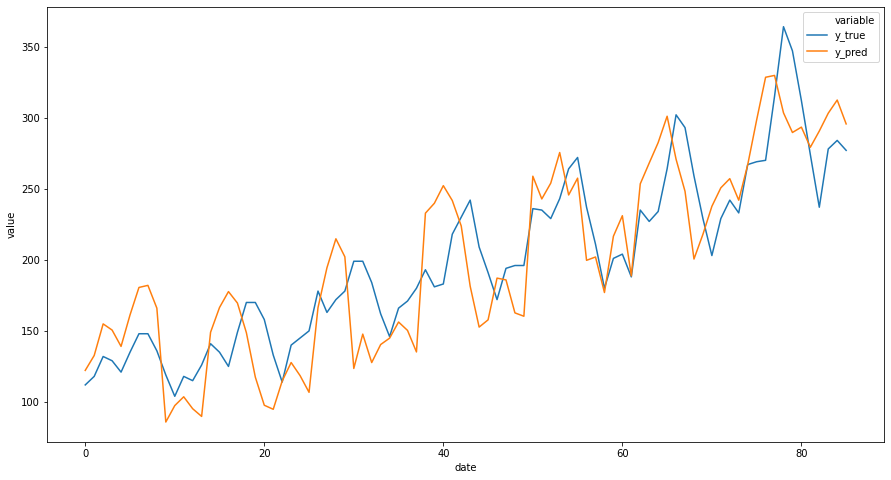

In [200]:
y_true, y_pred = predict(model=tabnet_regressor, x=X_train, y=y_train);
plot_results(y_true, y_pred)

BEST VALID SCORE FOR international-airline-passengers : 569.7008056640625
FINAL TEST SCORE FOR international-airline-passengers : 4599.493452264574


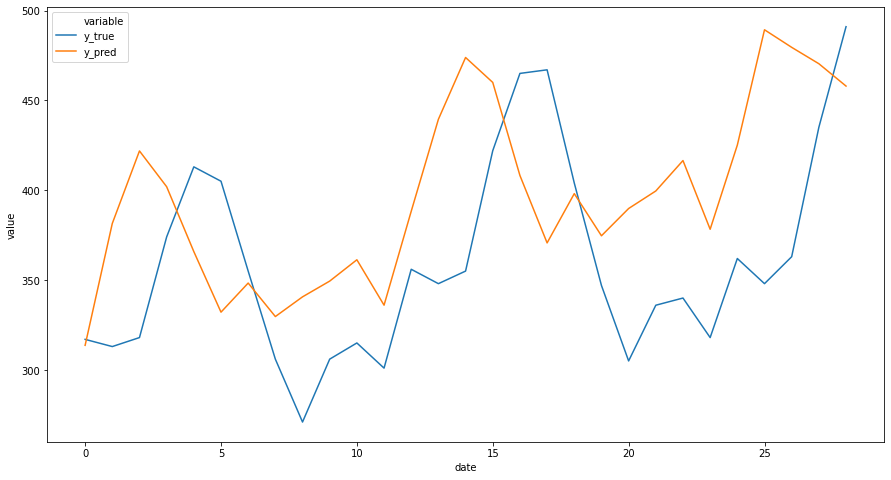

In [201]:
y_true, y_pred = predict(model=tabnet_regressor, x=X_val, y=y_val);
plot_results(y_true, y_pred)

BEST VALID SCORE FOR international-airline-passengers : 569.7008056640625
FINAL TEST SCORE FOR international-airline-passengers : 13168.386048964707


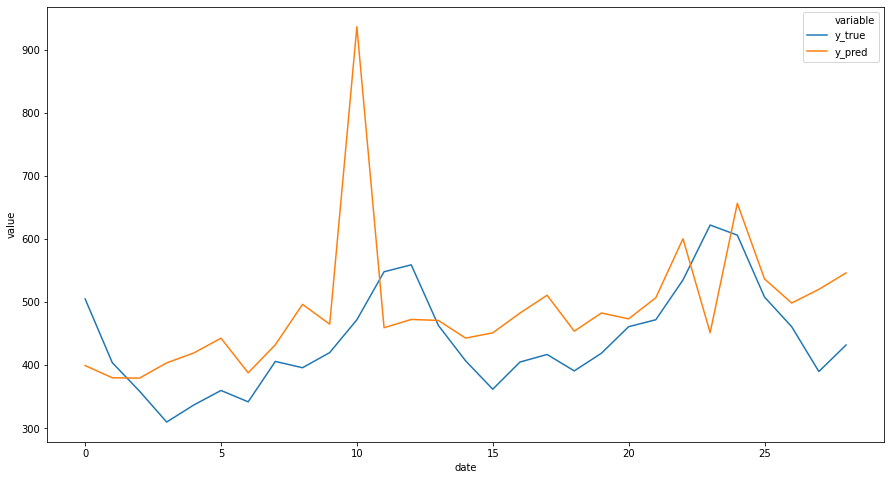

In [202]:
y_true, y_pred = predict(model=tabnet_regressor, x=X_test, y=y_test);
plot_results(y_true, y_pred)

# Global explainability : feat importance summing to 1

In [203]:
tabnet_regressor.feature_importances_

array([0.08086063, 0.01829566, 0.10005057, 0.0098951 , 0.29768747,
       0.        , 0.01246277, 0.0612676 , 0.00272837, 0.41675182,
       0.        , 0.        ])

# Local explainability and masks

In [204]:
explain_matrix, masks = tabnet_regressor.explain(X_test)

In [205]:
masks

{0: array([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 1.        ,
         0.        , 0.        ],
        [0.06021118, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.93978882,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 1.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 1.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 1.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 1.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,

In [206]:
from matplotlib import pyplot as plt
%matplotlib inline

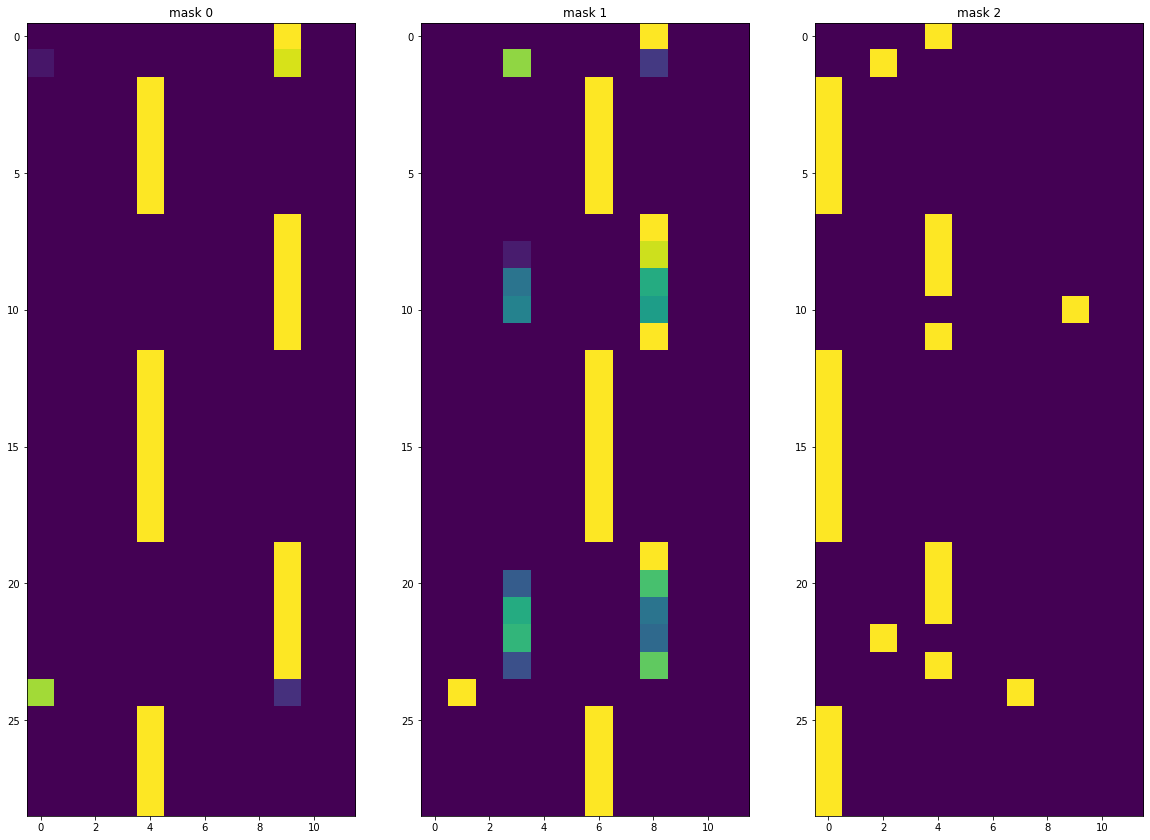

In [207]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")


---
---
---
---
# XGB

In [208]:
from xgboost import XGBRegressor

clf_xgb = XGBRegressor(max_depth=8,
    learning_rate=0.1,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='reg:linear',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=40,
        verbose=10)

[0]	validation_0-rmse:340.20285
Will train until validation_0-rmse hasn't improved in 40 rounds.
[10]	validation_0-rmse:188.21277
[20]	validation_0-rmse:119.94147
[30]	validation_0-rmse:87.50850
[40]	validation_0-rmse:68.79871
[50]	validation_0-rmse:58.71885
[60]	validation_0-rmse:52.76707
[70]	validation_0-rmse:49.80125
[80]	validation_0-rmse:47.66186
[90]	validation_0-rmse:46.80556
[100]	validation_0-rmse:46.11638
[110]	validation_0-rmse:45.54884
[120]	validation_0-rmse:45.11184
[130]	validation_0-rmse:44.85166
[140]	validation_0-rmse:44.66883
[150]	validation_0-rmse:44.61816
[160]	validation_0-rmse:44.51319
[170]	validation_0-rmse:44.46163
[180]	validation_0-rmse:44.42525
[190]	validation_0-rmse:44.38761
[200]	validation_0-rmse:44.35971
[210]	validation_0-rmse:44.33566
[220]	validation_0-rmse:44.31290
[230]	validation_0-rmse:44.31700
[240]	validation_0-rmse:44.33129
[250]	validation_0-rmse:44.33982
[260]	validation_0-rmse:44.34524
Stopping. Best iteration:
[222]	validation_0-rmse:44

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=-1, nthread=-1, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=0, silent=None, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=0)

BEST VALID SCORE FOR international-airline-passengers : 569.7008056640625
FINAL TEST SCORE FOR international-airline-passengers : 1149.1233867287283


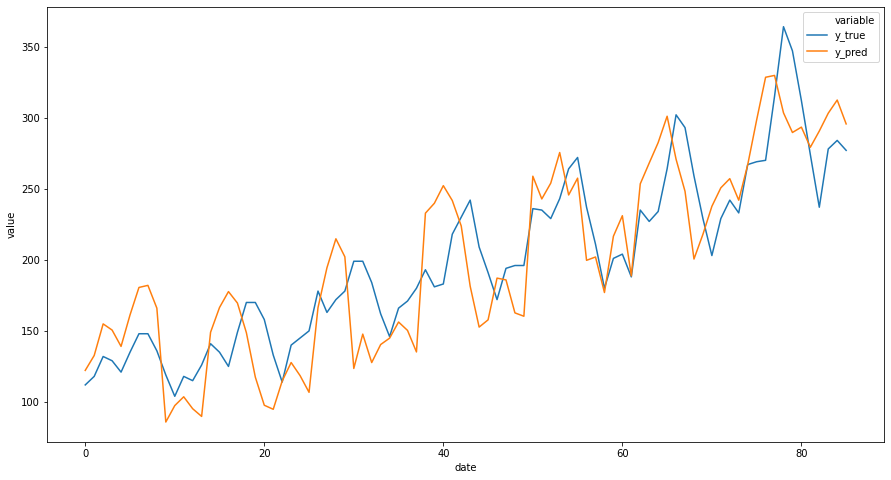

In [209]:
y_true, y_pred = predict(model=tabnet_regressor, x=X_train, y=y_train);
plot_results(y_true, y_pred)

BEST VALID SCORE FOR international-airline-passengers : 569.7008056640625
FINAL TEST SCORE FOR international-airline-passengers : 4599.493452264574


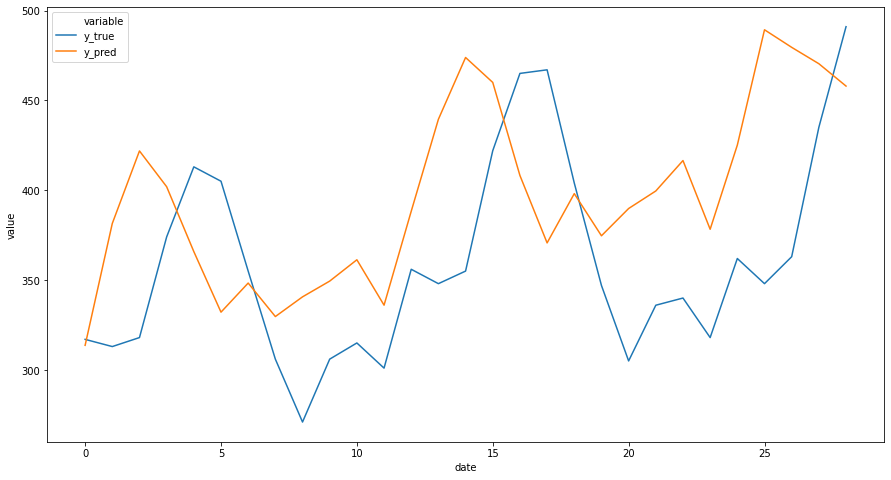

In [210]:
y_true, y_pred = predict(model=tabnet_regressor, x=X_val, y=y_val);
plot_results(y_true, y_pred)

BEST VALID SCORE FOR international-airline-passengers : 569.7008056640625
FINAL TEST SCORE FOR international-airline-passengers : 13168.386048964707


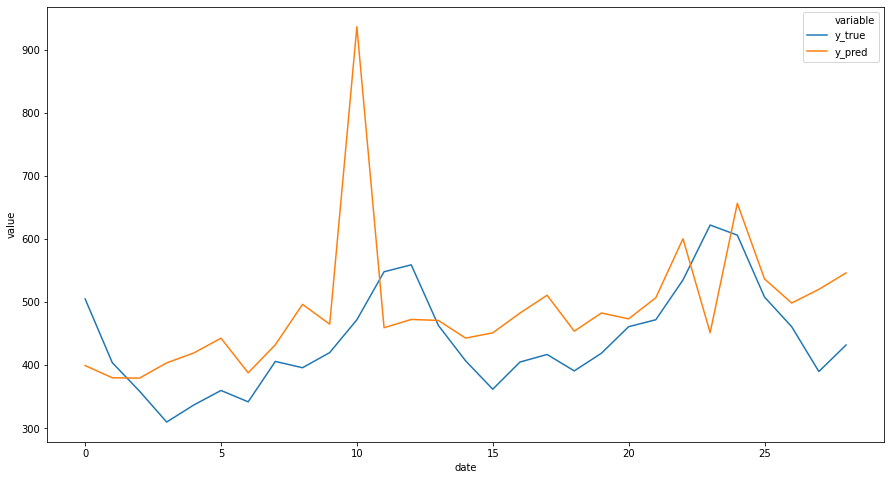

In [211]:
y_true, y_pred = predict(model=tabnet_regressor, x=X_test, y=y_test);
plot_results(y_true, y_pred)

In [212]:
clf_xgb.feature_importances_

array([0.05175126, 0.00246243, 0.00652993, 0.00223108, 0.00464645,
       0.00288416, 0.00695487, 0.0039266 , 0.00260819, 0.0171051 ,
       0.06913032, 0.8297697 ], dtype=float32)